[![pre-commit](https://img.shields.io/badge/pre--commit-enabled-brightgreen?logo=pre-commit&logoColor=white)](https://github.com/pre-commit/pre-commit) [![license](https://img.shields.io/badge/License-GPL%20v3-blue.svg)](https://github.com/LegrandNico/metadpy/blob/master/LICENSE) [![pip](https://badge.fury.io/py/metadpy.svg)](https://badge.fury.io/py/metadpy) [![travis](https://travis-ci.com/LegrandNico/metadpy.svg?branch=master)](https://travis-ci.com/LegandNico/metadpy) [![codecov](https://codecov.io/gh/LegrandNico/metadpy/branch/master/graph/badge.svg)](https://codecov.io/gh/LegrandNico/metadpy) [![black](https://img.shields.io/badge/code%20style-black-000000.svg)](https://github.com/psf/black) [![mypy](http://www.mypy-lang.org/static/mypy_badge.svg)](http://mypy-lang.org/) [![pip](https://badge.fury.io/py/metadpy.svg)](https://badge.fury.io/py/metadpy)

***

<img src="https://github.com/LegrandNico/metadpy/raw/master/docs/source/images/logo.png" align="left" alt="metadpy" height="250" HSPACE=30>

**metadpy** is a Python implementation of standard Bayesian models of behavioural metacognition. It is aimed to provide simple yet powerful functions to compute standard indexes and metrics of signal detection theory (SDT) and metacognitive efficiency (meta-d’ and hierarchical meta-d’) {cite:p}`fleming:2014,fleming:2017,maniscalo:2014,maniscalo:2012`. The only input required is a data frame encoding task performances and confidence ratings at the trial level.

**metadpy** is written in Python 3. It uses [Numpy](https://numpy.org/), [Scipy](https://www.scipy.org/) and [Pandas](https://pandas.pydata.org/>) for most of its operation, comprizing meta-d’ estimation using maximum likelihood estimation (MLE). The (Hierarchical) Bayesian modelling is implemented in [Aesara](https://github.com/aesara-devs/aesara) (now renamed [PyTensor](https://github.com/pymc-devs/pytensor) for versions of [pymc](https://docs.pymc.io/>) >5.0).

# Installation

The package can be installed using pip:

```shell
pip install metadpy
```

For most of the operations, the following packages are required:

* [Numpy](https://numpy.org/) (>=1.15)
* [Scipy](https://www.scipy.org/) (>=1.3.0)
* [Pandas](https://pandas.pydata.org/>) (>=0.24)
* [Matplotlib](https://matplotlib.org/) (>=3.0.2)
* [Seaborn](https://seaborn.pydata.org/) (>=0.9.0)

Bayesian models will require:

* [PyTensor](https://github.com/pymc-devs/pytensor)
* [pymc](https://docs.pymc.io/>) >5.0)

# Why metadpy?

metadpy stands for meta-d' (meta-d prime) in Python. meta-d' is a behavioural metric commonly used in consciousness and metacognition research. It is modelled to reflect metacognitive efficiency (i.e the relationship between subjective reports about performances and objective behaviour).

metadpy first aims to be the Python equivalent of the [hMeta-d toolbox](https://github.com/metacoglab/HMeta-d) (Matlab and R). It tries to make these models available to a broader open-source ecosystem and to ease their use via cloud computing interfaces. One notable difference is that While the [hMeta-d toolbox](https://github.com/metacoglab/HMeta-d) relies on JAGS for the Bayesian modelling of confidence data (see [**4**]) to analyse task performance and confidence ratings, metadpy is built on the top of [pymc](https://docs.pymc.io/>), and uses Hamiltonina Monte Carlo methods (NUTS).

For an extensive introduction to metadpy, you can navigate the following notebooks that are Python adaptations of the introduction to the [hMeta-d toolbox](https://github.com/metacoglab/HMeta-d) written in Matlab by Olivia Faul for the [Zurich Computational Psychiatry course](https://github.com/metacoglab/HMeta-d/tree/master/CPC_metacog_tutorial).

✏️ [Tutorials and examples](https://embodied-computation-group.github.io/metadpy/tutorials.html)

# Importing data

Classical metacognition experiments contain two phases: task performance and confidence ratings. The task performance could for example be the ability to distinguish the presence of a dot on the screen. By relating trials where stimuli are present or absent and the response provided by the participant (Can you see the dot: yes/no), it is possible to obtain the accuracy. The confidence rating is proposed to the participant when the response is made and should reflect how certain the participant is about his/her judgement.

An ideal observer would always associate very high confidence ratings with correct task-I responses, and very low confidence ratings with an incorrect task-1 response, while a participant with a low metacognitive efficiency will have a more mixed response pattern.

A minimal metacognition dataset will therefore consist in a data frame populated with 5 columns:
* `Stimuli`: Which of the two stimuli was presented [0 or 1].
* `Response`: The response made by the participant [0 or 1].
* `Accuracy`: Was the participant correct? [0 or 1].
* `Confidence`: The confidence level [can be continuous or discrete rating].
* `ntrial`: The trial number.

Due to the logical dependence between the `Stimuli`, `Responses` and `Accuracy` columns, in practice only two of those columns are necessary, the third being deduced from the others. Most of the functions in `metadpy` will accept DataFrames containing only two of these columns, and will automatically infer the missing information. Similarly, as the metacognition models described here does not incorporate the temporal dimension, the trial number is optional. 

`metadpy` includes a simulation function that will let you create one such data frame for one or many participants and condition, controlling for a variety of parameters. Here, we will simulate 200 trials from  participant having `d=1` and `c=0` (task performances) and a `meta-d=1.5` (metacognitive sensibility). The confidence ratings were provided using a 1-to-4 rating scale.

In [1]:
from metadpy.utils import responseSimulation

simulation = responseSimulation(d=1, metad=2.0, c=0, nRatings=4, nTrials=5000)
simulation.head()

,Stimuli,Responses,Accuracy,Confidence,nTrial,Subject
0,1,1,1,4,0,0
1,1,1,1,3,1,0
2,0,1,0,4,2,0
3,0,0,1,2,3,0
4,0,0,1,2,4,0


In [2]:
from metadpy.utils import trials2counts

nR_S1, nR_S2 = trials2counts(
    data=simulation,
    stimuli="Stimuli",
    accuracy="Accuracy",
    confidence="Confidence",
    nRatings=4,
)

In [3]:
nR_S1, nR_S2

(array([661, 413, 367, 288, 428, 216,  94,  33]),
 array([ 31,  92, 213, 435, 334, 382, 372, 641]))

## Data visualization

You can easily visualize metacognition results using one of the plotting functions. Here, we will use the `plot_confidence` and the `plot_roc` functions to visualize the metacognitive performance of our participant.

In [4]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from metadpy.plotting import plot_confidence, plot_roc

sns.set_context("talk")

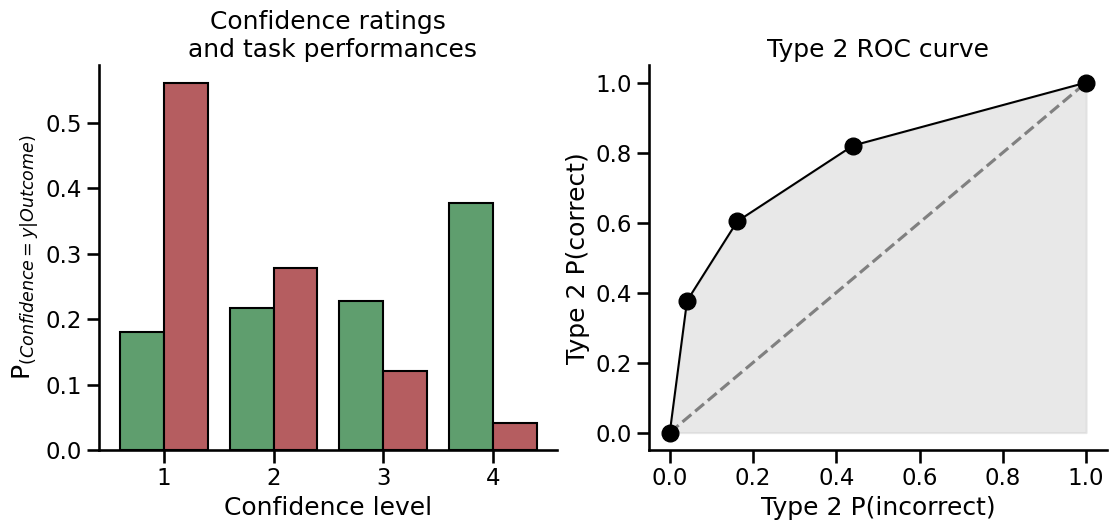

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
plot_confidence(nR_S1, nR_S2, ax=axs[0])
plot_roc(nR_S1, nR_S2, ax=axs[1])
sns.despine()

# Signal detection theory (SDT)

All metadpy functions are registred as Pandas flavors (see [pandas-flavor](https://pypi.org/project/pandas-flavor/)), which means that the functions can be called as a method from the result data frame. When using the default columns names (`Stimuli`, `Response`, `Accuracy`, `Confidence`), this significantly reduces the length of the function call, making your code more clean and readable.

In [6]:
simulation.criterion()

-0.0

In [7]:
simulation.dprime()

1.0007814013683562

In [8]:
simulation.rates()

(0.6916, 0.3084)

In [9]:
simulation.roc_auc(nRatings=4)

0.7737026395618145

In [10]:
simulation.scores()

(1729, 771, 771, 1729)

# Estimating meta dprime using Maximum Likelyhood Estimates (MLE)

In [13]:
from metadpy.mle import metad

results = metad(
    data=simulation,
    nRatings=4,
    stimuli="Stimuli",
    accuracy="Accuracy",
    confidence="Confidence",
    verbose=0,
)
results

,dprime,meta_d,m_ratio,m_diff
0,0.999911,1.939668,1.939841,0.939757


# Estimating meta-d' using Bayesian modeling

## Subject level

In [14]:
from metadpy.bayesian import hmetad

In [15]:
model, trace = hmetad(
    data=simulation,
    nRatings=4,
    stimuli="Stimuli",
    accuracy="Accuracy",
    confidence="Confidence",
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/lib/python3.8/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c1, d1, met

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


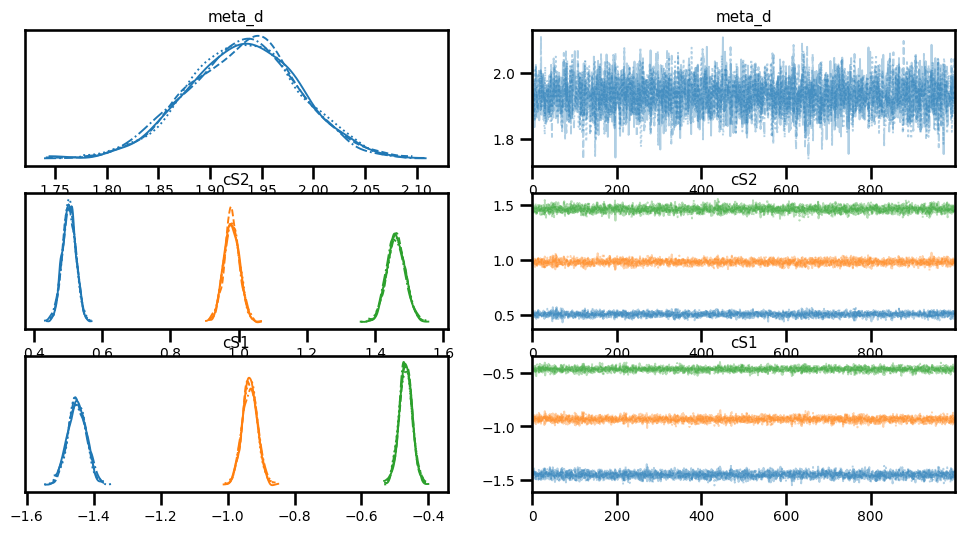

In [16]:
az.plot_trace(trace, var_names=["meta_d", "cS2", "cS1"]);

In [17]:
az.summary(trace, var_names=["meta_d", "cS2", "cS1"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
meta_d,1.932,0.053,1.838,2.037,0.001,0.001,3553.0,3181.0,1.0
cS2[0],0.503,0.020,0.467,0.541,0.000,0.000,4709.0,3514.0,1.0
cS2[1],0.980,0.023,0.936,1.020,0.000,0.000,3786.0,3177.0,1.0
cS2[2],1.461,0.027,1.410,1.511,0.000,0.000,3654.0,3425.0,1.0
cS1[0],-1.450,0.028,-1.502,-1.399,0.000,0.000,3844.0,3129.0,1.0
cS1[1],-0.934,0.023,-0.977,-0.892,0.000,0.000,3814.0,3521.0,1.0
cS1[2],-0.468,0.020,-0.507,-0.431,0.000,0.000,4362.0,3196.0,1.0


<img src = "https://raw.githubusercontent.com/embodied-computation-group/metadpy/master/docs/source/images/LabLogo.png" height ="100"><img src = "https://raw.githubusercontent.com/embodied-computation-group/metadpy/master/docs/source/images/AU.png" height ="100">

```{toctree}
---
hidden:
---
API <api.rst>
Tutorials <tutorials.md>
Cite <cite.md>
References <references.md>
```